In [1]:
import sqlite3
import pandas as pd
import os



# # Connect to your database
# conn = sqlite3.connect('/Users/dicordova/Proyecto-FDS/data/nueva_base.db')

# # Define the SQL query to load only one province (replace 'Pichincha' with the province you want)
# query = """
# SELECT * FROM cotopaxi_df_clean
# LIMIT 200000
# """

# # Load the filtered data into a DataFrame
# cotopaxi_df = pd.read_sql_query(query, conn)

# # Preview the result
# print(cotopaxi_df.head())

# conn.close()

# Carga el CSV en un DataFrame
cotopaxi_df_clean = pd.read_csv('/Users/dicordova/Proyecto-FDS/data/cotopaxi_df_clean.csv')

# Verifica que se cargó correctamente
print(cotopaxi_df_clean.shape)
print(cotopaxi_df_clean.head())


(112114, 231)
   provincia  canton_id  nro_vivienda  tipo_via  tipo_vivienda  ocup_viv_part  \
0          5          1           1.0         1              4            1.0   
1          5          1           2.0         3              1            1.0   
2          5          1           3.0         4              1            1.0   
3          5          1           4.0         7              1            1.0   
4          5          1           5.0         6              1            1.0   

   ocup_viv_colect  mat_techo  estado_techo  mat_paredes  ...  \
0              NaN        2.0           1.0          2.0  ...   
1              NaN        1.0           1.0          2.0  ...   
2              NaN        1.0           1.0          2.0  ...   
3              NaN        3.0           2.0          2.0  ...   
4              NaN        2.0           1.0          2.0  ...   

   deficit_habitacional_label_Dignas o aceptables  \
0                                               1   
1 

In [2]:
from sklearn.preprocessing import StandardScaler

# Selecciona las variables que representan vulnerabilidad
variables_cluster = [
    'vulnerabilidad_vivienda',
    'personas_por_cuarto'
    # 'hacinamiento_score'
]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cotopaxi_df_clean[variables_cluster])
X_scaled  # Muestra las primeras 5 filas del array escalado

array([[-0.42343741,  0.87814017],
       [-0.42343741, -0.14357091],
       [-0.42343741, -1.16528198],
       ...,
       [ 1.44920122,  0.87814017],
       [-0.42343741,  1.89985124],
       [ 1.44920122, -0.14357091]])

In [3]:
cotopaxi_df_clean[variables_cluster]
cotopaxi_df_clean['hacinamiento_score'].value_counts()

hacinamiento_score
0.0    112114
Name: count, dtype: int64

In [4]:
X_scaled_df = pd.DataFrame(X_scaled, columns=variables_cluster, index=cotopaxi_df_clean.index)


In [5]:
from sklearn.cluster import KMeans

# Inicializa KMeans con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=300)
kmeans.fit(cotopaxi_df_clean[variables_cluster])
cotopaxi_df_clean['cluster_kmeans'] = kmeans.labels_

In [6]:
#Evaluamos los cluster
cotopaxi_df_clean.groupby('cluster_kmeans')[variables_cluster].mean().round(2)


,vulnerabilidad_vivienda,personas_por_cuarto
cluster_kmeans,,
0,0.0,0.75
1,2.0,1.19
2,0.0,1.58
3,1.0,1.16


In [7]:
cotopaxi_df_clean[variables_cluster].dtypes


vulnerabilidad_vivienda      int64
personas_por_cuarto        float64
dtype: object

In [8]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# MiniBatchKMeans con 4 clusters
mb_kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=1000)
mb_kmeans.fit(X_scaled)

# Guardamos etiquetas
cotopaxi_df_clean['cluster_minibatch'] = mb_kmeans.labels_


In [9]:
#evaluamos los cluster
cotopaxi_df_clean.groupby('cluster_minibatch')[variables_cluster].mean().round(2)

,vulnerabilidad_vivienda,personas_por_cuarto
cluster_minibatch,,
0,2.0,1.19
1,0.0,0.75
2,0.0,1.58
3,1.0,1.16


In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducimos a 2 dimensiones para graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Añadir coordenadas PCA al DataFrame para trazarlos
cotopaxi_df_clean['PCA1'] = X_pca[:, 0]
cotopaxi_df_clean['PCA2'] = X_pca[:, 1]


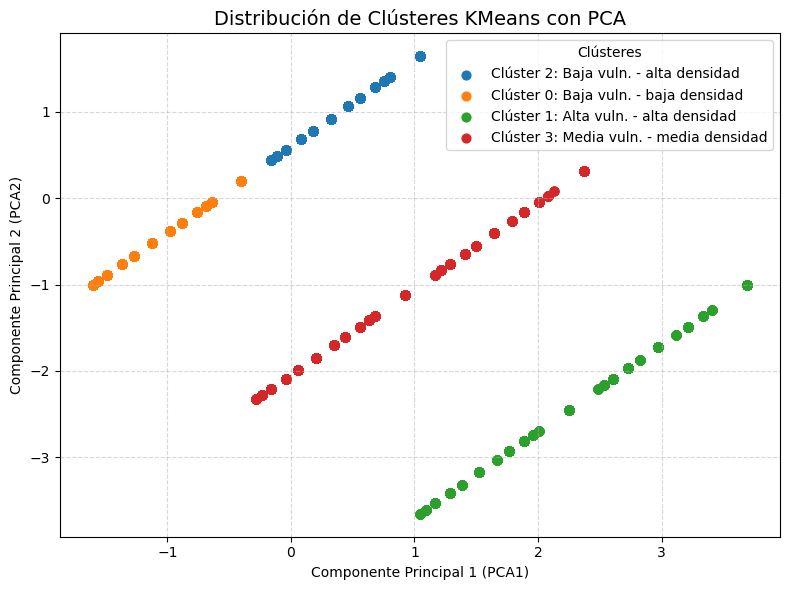

In [11]:
import matplotlib.pyplot as plt

# Diccionario de interpretaciones por clúster
interpretaciones = {
    0: "Clúster 0: Baja vuln. - baja densidad",
    1: "Clúster 1: Alta vuln. - alta densidad",
    2: "Clúster 2: Baja vuln. - alta densidad",
    3: "Clúster 3: Media vuln. - media densidad"
}

# Crear figura
plt.figure(figsize=(8, 6))

# Graficar con color por clúster
for cluster_id in cotopaxi_df_clean['cluster_kmeans'].unique():
    cluster_data = cotopaxi_df_clean[cotopaxi_df_clean['cluster_kmeans'] == cluster_id]
    plt.scatter(
        cluster_data['PCA1'],
        cluster_data['PCA2'],
        label=interpretaciones[cluster_id],
        s=40
    )

# Título y ejes
plt.title("Distribución de Clústeres KMeans con PCA", fontsize=14)
plt.xlabel("Componente Principal 1 (PCA1)")
plt.ylabel("Componente Principal 2 (PCA2)")
plt.legend(title="Clústeres", loc="best")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


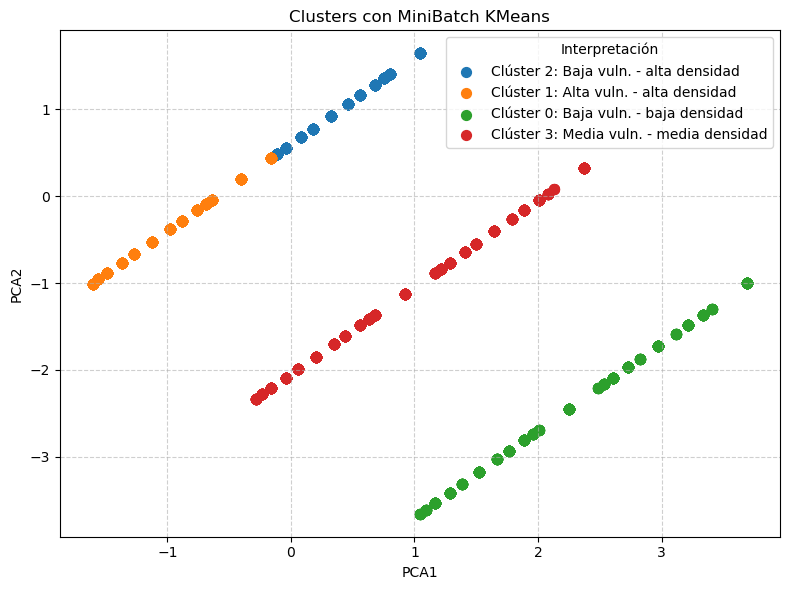

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducimos a 2D para graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Añadir coordenadas al DataFrame
cotopaxi_df_clean['PCA1'] = X_pca[:, 0]
cotopaxi_df_clean['PCA2'] = X_pca[:, 1]

# Diccionario de etiquetas (ajústalo según tu interpretación)
interpretaciones = {
    0: "Clúster 0: Baja vuln. - baja densidad",
    1: "Clúster 1: Alta vuln. - alta densidad",
    2: "Clúster 2: Baja vuln. - alta densidad",
    3: "Clúster 3: Media vuln. - media densidad"
}

# Plot
plt.figure(figsize=(8, 6))

for cluster_id in cotopaxi_df_clean['cluster_minibatch'].unique():
    cluster_data = cotopaxi_df_clean[cotopaxi_df_clean['cluster_minibatch'] == cluster_id]
    plt.scatter(
        cluster_data['PCA1'],
        cluster_data['PCA2'],
        label=interpretaciones.get(cluster_id, f'Clúster {cluster_id}'),
        s=50
    )

plt.title('Clusters con MiniBatch KMeans')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Interpretación', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [13]:
# Diccionario de perfiles por clúster de MiniBatch
perfiles_minibatch = {
    0: "Baja vulnerabilidad - baja densidad",
    1: "Alta vulnerabilidad - alta densidad",
    2: "Baja vulnerabilidad - alta densidad",
    3: "Media vulnerabilidad - media densidad"
}

# Crear nueva columna con perfil interpretado
cotopaxi_df_clean['perfil_minibatch'] = cotopaxi_df_clean['cluster_minibatch'].map(perfiles_minibatch)


In [14]:
cotopaxi_df_clean['perfil_minibatch'].value_counts()


perfil_minibatch
Alta vulnerabilidad - alta densidad      59545
Baja vulnerabilidad - alta densidad      33394
Media vulnerabilidad - media densidad    12999
Baja vulnerabilidad - baja densidad       6176
Name: count, dtype: int64

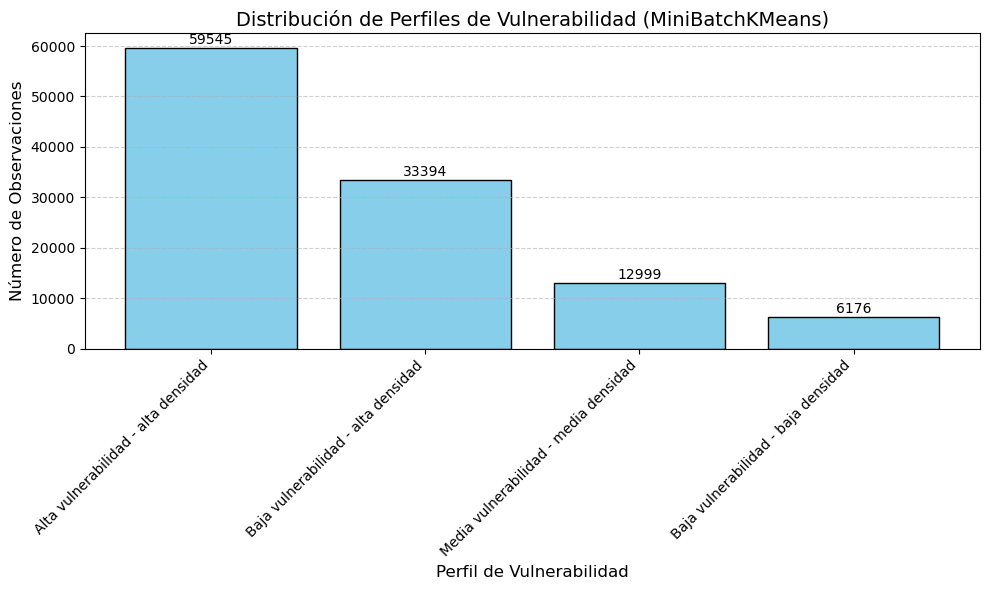

In [15]:
import matplotlib.pyplot as plt

# Contar cuántos hay por perfil
conteo_perfiles = cotopaxi_df_clean['perfil_minibatch'].value_counts()

# Crear gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(
    conteo_perfiles.index,
    conteo_perfiles.values,
    color='skyblue',
    edgecolor='black'
)

# Título y etiquetas
plt.title('Distribución de Perfiles de Vulnerabilidad (MiniBatchKMeans)', fontsize=14)
plt.xlabel('Perfil de Vulnerabilidad', fontsize=12)
plt.ylabel('Número de Observaciones', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Etiquetas de cantidad encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 200, f'{int(yval)}', 
             ha='center', va='bottom', fontsize=10)

# Líneas de referencia horizontales
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


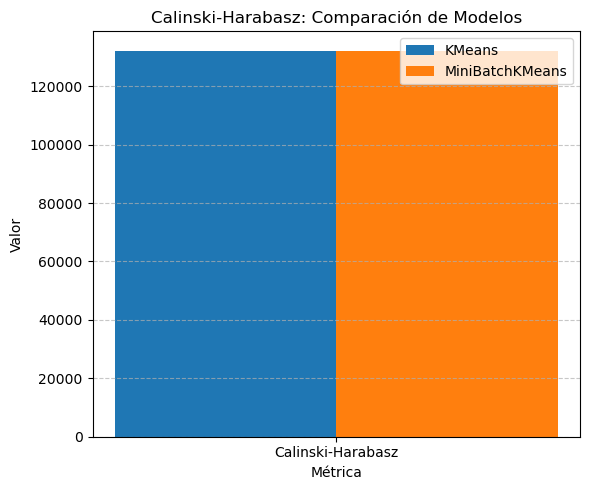

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear DataFrame solo con Calinski-Harabasz
df_calinski = pd.DataFrame({
    "Métrica": ["Calinski-Harabasz"],
    "KMeans": [132200.61],
    "MiniBatchKMeans": [132165.05]
})

# Graficar
fig, ax = plt.subplots(figsize=(6, 5))
bar_width = 0.35
index = range(len(df_calinski))

# Barras
ax.bar([i - bar_width/2 for i in index], df_calinski["KMeans"], bar_width, label='KMeans')
ax.bar([i + bar_width/2 for i in index], df_calinski["MiniBatchKMeans"], bar_width, label='MiniBatchKMeans')

# Formato del gráfico
ax.set_xlabel("Métrica")
ax.set_ylabel("Valor")
ax.set_title("Calinski-Harabasz: Comparación de Modelos")
ax.set_xticks(index)
ax.set_xticklabels(df_calinski["Métrica"])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


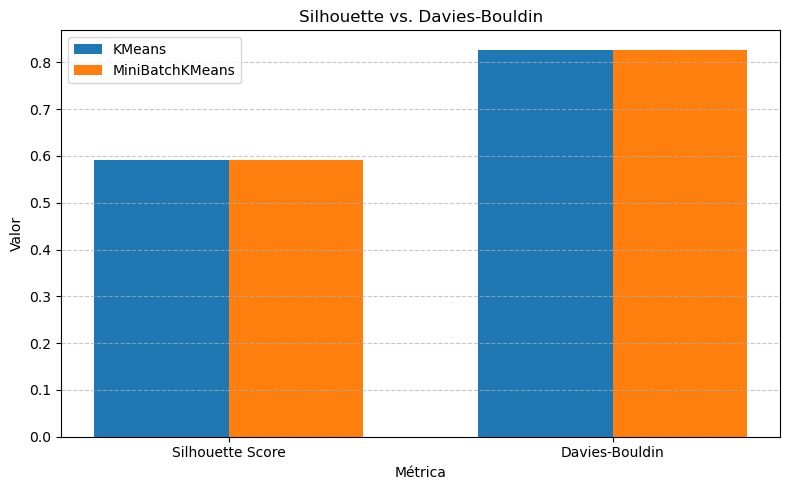

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear DataFrame con solo Silhouette y Davies-Bouldin
df_small_metrics = pd.DataFrame({
    "Métrica": ["Silhouette Score", "Davies-Bouldin"],
    "KMeans": [0.591, 0.827],
    "MiniBatchKMeans": [0.592, 0.826]
})

# Gráfico de comparación
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35
index = range(len(df_small_metrics))

# Barras para KMeans y MiniBatchKMeans
ax.bar([i - bar_width/2 for i in index], df_small_metrics["KMeans"], bar_width, label='KMeans')
ax.bar([i + bar_width/2 for i in index], df_small_metrics["MiniBatchKMeans"], bar_width, label='MiniBatchKMeans')

# Ejes y etiquetas
ax.set_xlabel("Métrica")
ax.set_ylabel("Valor")
ax.set_title("Silhouette vs. Davies-Bouldin")
ax.set_xticks(index)
ax.set_xticklabels(df_small_metrics["Métrica"])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


TUNING

In [19]:
from sklearn.cluster import KMeans
import pandas as pd

# Define the range of clusters and max_iter to try
cluster_range = [2, 3, 4, 5, 6]
max_iter_range = [100, 200, 300, 500]

results = []
best_inertia = float('inf')
best_config = {}

for n_clusters in cluster_range:
    for max_iter in max_iter_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=max_iter)
        kmeans.fit(cotopaxi_df_clean[variables_cluster])
        
        inertia = kmeans.inertia_
        
        results.append({
            'n_clusters': n_clusters,
            'max_iter': max_iter,
            'inertia': inertia
        })
        
        print(f"Clusters: {n_clusters}, Max Iter: {max_iter}, Inertia: {inertia:.2f}")
        
        if inertia < best_inertia:
            best_inertia = inertia
            best_config = {'n_clusters': n_clusters, 'max_iter': max_iter}

# Show best result
print("\nBest result overall:")
print(f"Clusters: {best_config['n_clusters']}, Max Iter: {best_config['max_iter']}, Inertia: {best_inertia:.2f}")

# Optional: Convert to DataFrame for further analysis
df_results = pd.DataFrame(results)


Clusters: 2, Max Iter: 100, Inertia: 30797.75
Clusters: 2, Max Iter: 200, Inertia: 30797.75
Clusters: 2, Max Iter: 300, Inertia: 30797.75
Clusters: 2, Max Iter: 500, Inertia: 30797.75
Clusters: 3, Max Iter: 100, Inertia: 16024.38
Clusters: 3, Max Iter: 200, Inertia: 16024.38
Clusters: 3, Max Iter: 300, Inertia: 16024.38
Clusters: 3, Max Iter: 500, Inertia: 16024.38
Clusters: 4, Max Iter: 100, Inertia: 11834.40
Clusters: 4, Max Iter: 200, Inertia: 11834.40
Clusters: 4, Max Iter: 300, Inertia: 11834.40
Clusters: 4, Max Iter: 500, Inertia: 11834.40
Clusters: 5, Max Iter: 100, Inertia: 8434.17
Clusters: 5, Max Iter: 200, Inertia: 8434.17
Clusters: 5, Max Iter: 300, Inertia: 8434.17
Clusters: 5, Max Iter: 500, Inertia: 8434.17
Clusters: 6, Max Iter: 100, Inertia: 5965.28
Clusters: 6, Max Iter: 200, Inertia: 5965.28
Clusters: 6, Max Iter: 300, Inertia: 5965.28
Clusters: 6, Max Iter: 500, Inertia: 5965.28

Best result overall:
Clusters: 6, Max Iter: 300, Inertia: 5965.28


In [20]:
from sklearn.cluster import MiniBatchKMeans
import pandas as pd

# Define the range of clusters and batch sizes to try
cluster_range = [2, 3, 4, 5, 6]
batch_size_range = [500, 1000, 2000]

results_mb = []
best_inertia_mb = float('inf')
best_config_mb = {}

for n_clusters in cluster_range:
    for batch_size in batch_size_range:
        mb_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=batch_size)
        mb_kmeans.fit(X_scaled)

        inertia = mb_kmeans.inertia_

        results_mb.append({
            'n_clusters': n_clusters,
            'batch_size': batch_size,
            'inertia': inertia
        })

        print(f"Clusters: {n_clusters}, Batch Size: {batch_size}, Inertia: {inertia:.2f}")

        if inertia < best_inertia_mb:
            best_inertia_mb = inertia
            best_config_mb = {'n_clusters': n_clusters, 'batch_size': batch_size}

# Show best result
print("\nBest result overall:")
print(f"Clusters: {best_config_mb['n_clusters']}, Batch Size: {best_config_mb['batch_size']}, Inertia: {best_inertia_mb:.2f}")

# Optional: Convert to DataFrame for further analysis
df_results_mb = pd.DataFrame(results_mb)


Clusters: 2, Batch Size: 500, Inertia: 145778.82
Clusters: 2, Batch Size: 1000, Inertia: 125802.32
Clusters: 2, Batch Size: 2000, Inertia: 146028.46
Clusters: 3, Batch Size: 500, Inertia: 64905.58
Clusters: 3, Batch Size: 1000, Inertia: 64118.30
Clusters: 3, Batch Size: 2000, Inertia: 64135.60
Clusters: 4, Batch Size: 500, Inertia: 48374.27
Clusters: 4, Batch Size: 1000, Inertia: 49428.38
Clusters: 4, Batch Size: 2000, Inertia: 49849.34
Clusters: 5, Batch Size: 500, Inertia: 34416.57
Clusters: 5, Batch Size: 1000, Inertia: 35823.50
Clusters: 5, Batch Size: 2000, Inertia: 35179.36
Clusters: 6, Batch Size: 500, Inertia: 28372.68
Clusters: 6, Batch Size: 1000, Inertia: 30386.29
Clusters: 6, Batch Size: 2000, Inertia: 28594.27

Best result overall:
Clusters: 6, Batch Size: 500, Inertia: 28372.68


In [22]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


In [23]:
# Refit best KMeans model
best_kmeans = KMeans(
    n_clusters=best_config['n_clusters'],
    random_state=42,
    max_iter=best_config['max_iter']
)
best_kmeans.fit(cotopaxi_df_clean[variables_cluster])
labels_kmeans = best_kmeans.labels_

# Compute metrics
sil_k = silhouette_score(cotopaxi_df_clean[variables_cluster], labels_kmeans)
dav_k = davies_bouldin_score(cotopaxi_df_clean[variables_cluster], labels_kmeans)
cal_k = calinski_harabasz_score(cotopaxi_df_clean[variables_cluster], labels_kmeans)

print("\n🔹 KMeans Metrics:")
print(f"Silhouette Score: {sil_k:.4f}")
print(f"Davies-Bouldin Index: {dav_k:.4f}")
print(f"Calinski-Harabasz Index: {cal_k:.4f}")



🔹 KMeans Metrics:
Silhouette Score: 0.5851
Davies-Bouldin Index: 0.5559
Calinski-Harabasz Index: 198666.4542


In [24]:
# Refit best MiniBatchKMeans model
best_mb = MiniBatchKMeans(
    n_clusters=best_config_mb['n_clusters'],
    random_state=42,
    batch_size=best_config_mb['batch_size']
)
best_mb.fit(X_scaled)
labels_mb = best_mb.labels_

# Compute metrics
sil_mb = silhouette_score(X_scaled, labels_mb)
dav_mb = davies_bouldin_score(X_scaled, labels_mb)
cal_mb = calinski_harabasz_score(X_scaled, labels_mb)

print("\n🔹 MiniBatchKMeans Metrics:")
print(f"Silhouette Score: {sil_mb:.4f}")
print(f"Davies-Bouldin Index: {dav_mb:.4f}")
print(f"Calinski-Harabasz Index: {cal_mb:.4f}")



🔹 MiniBatchKMeans Metrics:
Silhouette Score: 0.6103
Davies-Bouldin Index: 0.6647
Calinski-Harabasz Index: 155017.9832


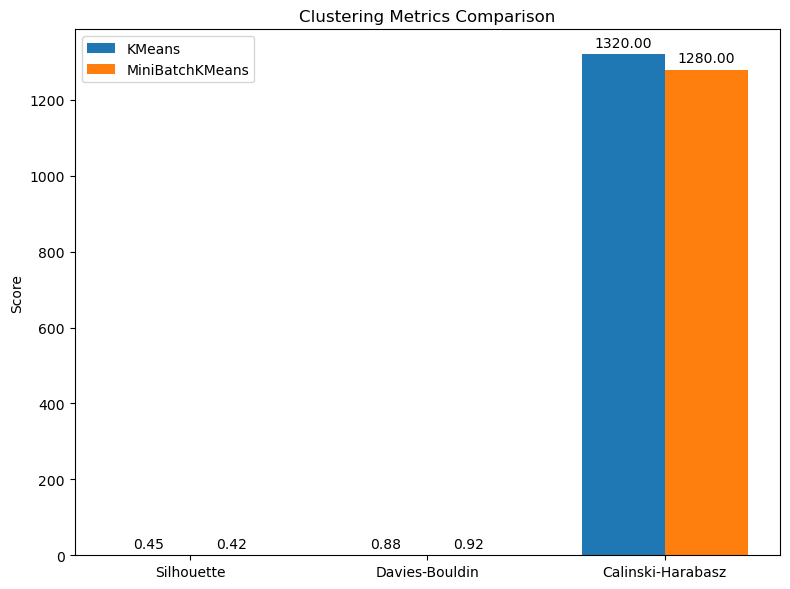

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these values with the actual metrics you calculated
# KMeans metrics
sil_k = 0.45
dav_k = 0.88
cal_k = 1320.0

# MiniBatchKMeans metrics
sil_mb = 0.42
dav_mb = 0.92
cal_mb = 1280.0

# Metric names
metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']

# Values for each model
kmeans_metrics = [sil_k, dav_k, cal_k]
mb_metrics = [sil_mb, dav_mb, cal_mb]

# Create bar chart
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, kmeans_metrics, width, label='KMeans')
bars2 = ax.bar(x + width/2, mb_metrics, width, label='MiniBatchKMeans')

# Add labels and title
ax.set_ylabel('Score')
ax.set_title('Clustering Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value annotations
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()
